In [1]:
import csv
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from xgboost import plot_tree
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

## Première approche
On utilise CSV reader afin de pouvoir lire les touches utilisées et les ranger dans un dictionnaire
On calcule les fréquences pour chaque hotkey

In [2]:
"""
rows_list = []
train_data = pd.DataFrame()

with open('../input/starcraft-2-player-prediction-challenge-2020/TRAIN.CSV', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        #row = row[:150]
        row = list(filter(lambda term : not term.startswith('t'), row))
        
        dictionary={
                'id' : row[0],
                'Race': row[1], 
                'Base': 0,
                'SingleMineral': 0,
                's': 0,
                'hotkey00': 0,
                'hotkey01': 0,
                'hotkey02': 0,
                'hotkey10': 0,
                'hotkey11': 0,
                'hotkey12': 0,
                'hotkey20': 0,
                'hotkey21': 0,
                'hotkey22': 0,
                'hotkey30': 0,
                'hotkey31': 0,
                'hotkey32': 0,
                'hotkey40': 0,
                'hotkey41': 0,
                'hotkey42': 0,
                'hotkey50': 0,
                'hotkey51': 0,
                'hotkey52': 0,
                'hotkey60': 0,
                'hotkey61': 0,
                'hotkey62': 0,
                'hotkey70': 0,
                'hotkey71': 0,
                'hotkey72': 0,
                'hotkey80': 0,
                'hotkey81': 0,
                'hotkey82': 0,
                'hotkey90': 0,
                'hotkey91': 0,
                'hotkey92': 0,
            }
        
        race = dictionary['Race']
        if race == 'Zerg':
            dictionary['Race'] = 0
        elif race == 'Terran':
            dictionary['Race'] = 1
        else:
            dictionary['Race'] = 2
                    
        row.pop(0)   
        row.pop(0)        

        actionsTotales = 0
        for action in row:
            actionsTotales = actionsTotales + 1
            value = dictionary.get(action)
            
            if value is None:
                print('This action should exist')
            else:
                dictionary[action] = value + 1
            
        for item in dictionary:
            if item != 'Race' and item != 'id':
                    if dictionary[item] != 0:
                        dictionary[item]=dictionary[item]/actionsTotales
                    else:
                        dictionary[item]=0.
             
        rows_list.append(dictionary)

train_data = train_data.append(rows_list)
"""

"\nrows_list = []\ntrain_data = pd.DataFrame()\n\nwith open('../input/starcraft-2-player-prediction-challenge-2020/TRAIN.CSV', 'r') as file:\n    reader = csv.reader(file)\n    for row in reader:\n        #row = row[:150]\n        row = list(filter(lambda term : not term.startswith('t'), row))\n        \n        dictionary={\n                'id' : row[0],\n                'Race': row[1], \n                'Base': 0,\n                'SingleMineral': 0,\n                's': 0,\n                'hotkey00': 0,\n                'hotkey01': 0,\n                'hotkey02': 0,\n                'hotkey10': 0,\n                'hotkey11': 0,\n                'hotkey12': 0,\n                'hotkey20': 0,\n                'hotkey21': 0,\n                'hotkey22': 0,\n                'hotkey30': 0,\n                'hotkey31': 0,\n                'hotkey32': 0,\n                'hotkey40': 0,\n                'hotkey41': 0,\n                'hotkey42': 0,\n                'hotkey50': 0,\n    

In [3]:
"""
rows_list_test = []
test_data = pd.DataFrame()

with open('../input/starcraft-2-player-prediction-challenge-2020/TEST.CSV', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        #row = row[:150]
        row = list(filter(lambda term : not term.startswith('t'), row))
        dictionary={
                'Race': row[0], 
                'Base': 0,
                'SingleMineral': 0,
                's': 0,
                'hotkey00': 0,
                'hotkey01': 0,
                'hotkey02': 0,
                'hotkey10': 0,
                'hotkey11': 0,
                'hotkey12': 0,
                'hotkey20': 0,
                'hotkey21': 0,
                'hotkey22': 0,
                'hotkey30': 0,
                'hotkey31': 0,
                'hotkey32': 0,
                'hotkey40': 0,
                'hotkey41': 0,
                'hotkey42': 0,
                'hotkey50': 0,
                'hotkey51': 0,
                'hotkey52': 0,
                'hotkey60': 0,
                'hotkey61': 0,
                'hotkey62': 0,
                'hotkey70': 0,
                'hotkey71': 0,
                'hotkey72': 0,
                'hotkey80': 0,
                'hotkey81': 0,
                'hotkey82': 0,
                'hotkey90': 0,
                'hotkey91': 0,
                'hotkey92': 0,
            }
        
        race = dictionary['Race']
        if race == 'Zerg':
            dictionary['Race'] = 0
        elif race == 'Terran':
            dictionary['Race'] = 1
        else:
            dictionary['Race'] = 2
                    
        row.pop(0)        

        actionsTotales = 0
        for action in row:
            actionsTotales = actionsTotales + 1
            value = dictionary.get(action)
            
            if value is None:
                print('This action should exist')
            else:
                dictionary[action] = value + 1
            
        for item in dictionary:
            if item != 'Race' and item != 'id':
                    if dictionary[item] != 0:
                        dictionary[item]=dictionary[item]/actionsTotales
                    else:
                        dictionary[item]=0.
             
        rows_list_test.append(dictionary)

test_data = test_data.append(rows_list_test)
"""

"\nrows_list_test = []\ntest_data = pd.DataFrame()\n\nwith open('../input/starcraft-2-player-prediction-challenge-2020/TEST.CSV', 'r') as file:\n    reader = csv.reader(file)\n    for row in reader:\n        #row = row[:150]\n        row = list(filter(lambda term : not term.startswith('t'), row))\n        dictionary={\n                'Race': row[0], \n                'Base': 0,\n                'SingleMineral': 0,\n                's': 0,\n                'hotkey00': 0,\n                'hotkey01': 0,\n                'hotkey02': 0,\n                'hotkey10': 0,\n                'hotkey11': 0,\n                'hotkey12': 0,\n                'hotkey20': 0,\n                'hotkey21': 0,\n                'hotkey22': 0,\n                'hotkey30': 0,\n                'hotkey31': 0,\n                'hotkey32': 0,\n                'hotkey40': 0,\n                'hotkey41': 0,\n                'hotkey42': 0,\n                'hotkey50': 0,\n                'hotkey51': 0,\n           

## Deuxième approche
On va tout d'abord importer toutes les actions dans un dataframe. Nous allons séparer les races et les minéraux des auttres hotkey.

In [4]:
def read_train(f):
    data = []
    with open(f, 'r') as file:
        for row in file:
            row_data = row.replace('\n','').split(',')
            profile_id, race, actions = row_data[0],row_data[1],row_data[2:]
            data.append([profile_id,race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['id', 'race','actions'])
    return df
    
def read_test(f):
    data = []
    with open(f, 'r') as file:
        for row in file:
            row_data = row.replace('\n','').split(',')
            race, actions = row_data[0],row_data[1:]
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    return df

In [5]:
train_data = read_train('TRAIN.CSV')
test_data = read_test('TEST.CSV')

In [6]:
train_data.head()

,id,race,actions
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,"Base, s, s, s, s, s, t5, Base, s, hotkey30, ho..."
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,"s, Base, s, s, Base, s, s, Base, s, t5, hotkey..."
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,"Base, s, s, Base, s, s, s, t5, Base, s, hotkey..."
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."


In [7]:
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hot..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotke..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, ho..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, h..."


### Analyse des données brutes

Analyse de la répartition par terrain

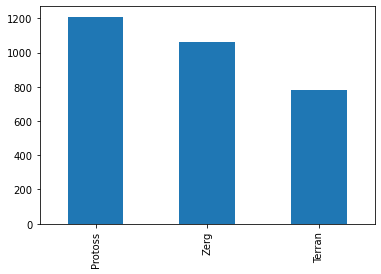

In [8]:
races = train_data['race'].value_counts()
plot = races.plot.bar()

Observation des profils sur lesquels nous disposons de beaucoup de données

In [9]:
train_data['id'].value_counts()

http://kr.battle.net/sc2/en/profile/2348639/1/ParalyzE/        58
http://kr.battle.net/sc2/en/profile/2342419/1/soO/             51
http://kr.battle.net/sc2/en/profile/2341467/1/Classic/         50
http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/        44
http://kr.battle.net/sc2/en/profile/2332264/1/Zest/            42
                                                               ..
http://xx.battle.net/sc2/en/profile/406/1/INnoVation/           4
http://kr.battle.net/sc2/en/profile/2344728/1/Ryung/            4
http://xx.battle.net/sc2/en/profile/405/1/MMA/                  4
http://eu.battle.net/sc2/en/profile/3434150/1/llllllllllll/     4
http://us.battle.net/sc2/en/profile/2768741/1/CatZ/             4
Name: id, Length: 200, dtype: int64

Puis création d'une nouvelle fonction pour pouvoir prendre en compte les temps utilisés sur chaque hotkey

In [10]:
hotkeys = ['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']


def build_features(dataframe):
    feature_set = []
    ids = []
    for index, row in dataframe.iterrows():
        ids.append(row[0])
        hotkey_counter = {hotkey:0 for hotkey in hotkeys}
        hotkey_counter_t0 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t5 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t15 = {hotkey:0 for hotkey in hotkeys} 
        hotkey_counter_t30 = {hotkey:0 for hotkey in hotkeys}
        hotkey_counter_t60 = {hotkey:0 for hotkey in hotkeys}
        actions = row["actions"]
        cpt = 1
        cpt_t0 = 1
        cpt_t5 = 1
        cpt_t15 = 1
        cpt_t30 = 1
        cpt_t60 = 1
        time = 0
        for action in actions.split(','):
            action = action.strip()
            if action in hotkeys:
                hotkey_counter[action]+=1
                cpt+=1
            if 't5' in action :
                time = 5
            if 't15' in action :
                time = 15
            if 't30' in action :
                time = 30
            if 't60' in action :
                time = 60
            if 't90' in action :
                break
            if action in hotkeys and time == 0 :
                hotkey_counter_t0[action]+=1
                cpt_t0+=1
            if action in hotkeys and time == 5 :
                hotkey_counter_t5[action]+=1
                cpt_t5+=1
            if action in hotkeys and time == 15 :
                hotkey_counter_t15[action]+=1
                cpt_t15+=1
            if action in hotkeys and time == 30 :
                hotkey_counter_t30[action]+=1
                cpt_t30+=1
            if action in hotkeys and time == 60 :
                hotkey_counter_t60[action]+=1
                cpt_t60+=1
        data = [row['race'], *[hotkey_counter[action]/cpt for action in hotkeys], *[hotkey_counter_t0[action]/cpt_t0 for action in hotkeys], *[hotkey_counter_t5[action]/cpt_t5 for action in hotkeys], *[hotkey_counter_t15[action]/cpt_t15 for action in hotkeys], *[hotkey_counter_t30[action]/cpt_t30 for action in hotkeys], *[hotkey_counter_t60[action]/cpt_t60 for action in hotkeys]]
        feature_set.append(data)
    feature_df = pd.DataFrame(feature_set, columns=['race', *hotkeys, *[hotkeys+'_t0' for hotkeys in hotkeys], *[hotkeys+'_t5' for hotkeys in hotkeys], *[hotkeys+'_t15' for hotkeys in hotkeys], *[hotkeys+'_t30' for hotkeys in hotkeys], *[hotkeys+'_t60' for hotkeys in hotkeys]])
    return feature_df

In [11]:
feature_df = build_features(train_data)

In [12]:
feature_df

,race,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,...,hotkey70_t60,hotkey71_t60,hotkey72_t60,hotkey80_t60,hotkey81_t60,hotkey82_t60,hotkey90_t60,hotkey91_t60,hotkey92_t60,s_t60
0,Protoss,0.019608,0.009804,0.009804,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492537
1,Protoss,0.020408,0.000000,0.000000,0.0,0.0,0.013605,0.0,0.115646,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254237
2,Protoss,0.014925,0.000000,0.007463,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508475
3,Protoss,0.024390,0.000000,0.000000,0.0,0.0,0.008130,0.0,0.048780,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404255
4,Protoss,0.016807,0.000000,0.008403,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,Terran,0.000000,0.000000,0.003521,0.0,0.0,0.003521,0.0,0.000000,0.003521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242718
3048,Terran,0.000000,0.011472,0.000000,0.0,0.0,0.009560,0.0,0.307839,0.001912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191257
3049,Terran,0.000000,0.003831,0.003831,0.0,0.0,0.003831,0.0,0.000000,0.003831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
3050,Terran,0.000000,0.026362,0.000000,0.0,0.0,0.007030,0.0,0.286467,0.001757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213542


Nous allons à présent sélectionner les id pour pouvoir entraîner nos arbres de décision

In [13]:
target = train_data.iloc[:,0]
target

0       http://eu.battle.net/sc2/en/profile/4234852/1/...
1       http://eu.battle.net/sc2/en/profile/3074362/1/...
2       http://eu.battle.net/sc2/en/profile/4234852/1/...
3       http://eu.battle.net/sc2/en/profile/3074362/1/...
4       http://eu.battle.net/sc2/en/profile/4234852/1/...
                              ...                        
3047       http://xx.battle.net/sc2/en/profile/405/1/MMA/
3048    http://xx.battle.net/sc2/en/profile/410/1/STBo...
3049       http://xx.battle.net/sc2/en/profile/405/1/MMA/
3050    http://xx.battle.net/sc2/en/profile/410/1/STBo...
3051       http://xx.battle.net/sc2/en/profile/405/1/MMA/
Name: id, Length: 3052, dtype: object

## Analyse graphique des features

On veut regarder quelle hotkey est la plus utilisée

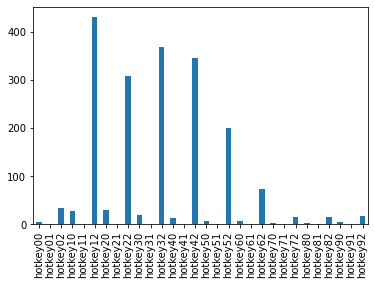

In [14]:
plot_data = feature_df.iloc[:,3:33]

all_hotkeys = plot_data.sum(axis=0)

all_hotkeys.plot(kind='bar')

On observe ici que la hotkey la plus représentée est la hotkey12

## Decision trees

On va appliquer des transformations sur la colonne 'race' pour adapter les labels à un decision tree

In [15]:
feature_df['race'] = LabelEncoder().fit_transform(feature_df['race'])
feature_df

,race,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,...,hotkey70_t60,hotkey71_t60,hotkey72_t60,hotkey80_t60,hotkey81_t60,hotkey82_t60,hotkey90_t60,hotkey91_t60,hotkey92_t60,s_t60
0,0,0.019608,0.009804,0.009804,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492537
1,0,0.020408,0.000000,0.000000,0.0,0.0,0.013605,0.0,0.115646,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254237
2,0,0.014925,0.000000,0.007463,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508475
3,0,0.024390,0.000000,0.000000,0.0,0.0,0.008130,0.0,0.048780,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404255
4,0,0.016807,0.000000,0.008403,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,1,0.000000,0.000000,0.003521,0.0,0.0,0.003521,0.0,0.000000,0.003521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242718
3048,1,0.000000,0.011472,0.000000,0.0,0.0,0.009560,0.0,0.307839,0.001912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191257
3049,1,0.000000,0.003831,0.003831,0.0,0.0,0.003831,0.0,0.000000,0.003831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
3050,1,0.000000,0.026362,0.000000,0.0,0.0,0.007030,0.0,0.286467,0.001757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213542


In [16]:
test_features = build_features(test_data)
test_features['race']= LabelEncoder().fit_transform(test_features['race'])
test_features.head()

,race,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,...,hotkey70_t60,hotkey71_t60,hotkey72_t60,hotkey80_t60,hotkey81_t60,hotkey82_t60,hotkey90_t60,hotkey91_t60,hotkey92_t60,s_t60
0,2,0.000000,0.0,0.022082,0.0,0.334385,0.003155,0.0,0.022082,0.003155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333
1,1,0.000000,0.0,0.004149,0.0,0.000000,0.004149,0.0,0.190871,0.004149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154472
2,0,0.007782,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.019455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425287
3,2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.006803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.409836
4,0,0.021739,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.477273


On calcule avec un arbre de décision XGboost

In [17]:
"""
xgb_model = xgb.XGBClassifier()

xgb_model.fit(feature_df, target)
predictions_xgboost = xgb_model.predict(test_features)

predictions_xgboost
"""

'\nxgb_model = xgb.XGBClassifier()\n\nxgb_model.fit(feature_df, target)\npredictions_xgboost = xgb_model.predict(test_features)\n\npredictions_xgboost\n'

In [18]:
"""
submission = pd.DataFrame({'prediction': predictions_xgboost})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))

filename = 'Starcraft predictions xgboost.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)
"""

"\nsubmission = pd.DataFrame({'prediction': predictions_xgboost})\nsubmission.insert(0, 'RowId', range(1, 1 + len(submission)))\n\nfilename = 'Starcraft predictions xgboost.csv'\nsubmission.to_csv(filename,index=False)\n\nprint('Saved file: ' + filename)\n"

In [20]:
#plot_tree(xgb_model)

On va maintenant utiliser un decision tree classifier

In [21]:
dt = DecisionTreeClassifier(min_samples_split=3, random_state=99)
dt.fit(feature_df, target)

predictions_dt = dt.predict(test_features)

predictions_dt

array(['http://eu.battle.net/sc2/en/profile/3538115/1/Golden/',
       'http://kr.battle.net/sc2/en/profile/2344031/1/Cure/',
       'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/',
       'http://us.battle.net/sc2/en/profile/5068246/1/yoeFWSlam/',
       'http://kr.battle.net/sc2/en/profile/2344728/1/Shine/',
       'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/',
       'http://us.battle.net/sc2/en/profile/2553612/1/puCK/',
       'http://eu.battle.net/sc2/en/profile/884897/1/LiquidSnute/',
       'http://eu.battle.net/sc2/en/profile/2526293/1/Krr/',
       'http://eu.battle.net/sc2/en/profile/377576/1/LiquidMaNa/',
       'http://eu.battle.net/sc2/en/profile/284466/1/EGDeMusliM/',
       'http://eu.battle.net/sc2/en/profile/788178/1/Nerchio/',
       'http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/',
       'http://eu.battle.net/sc2/en/profile/3973341/1/yoeFWSan/',
       'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/',
       'http://eu.battle.n

In [22]:
"""
submission = pd.DataFrame({'prediction': predictions_dt})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))


filename = 'Starcraft predictions dt.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)
"""

"\nsubmission = pd.DataFrame({'prediction': predictions_dt})\nsubmission.insert(0, 'RowId', range(1, 1 + len(submission)))\n\n\nfilename = 'Starcraft predictions dt.csv'\nsubmission.to_csv(filename,index=False)\n\nprint('Saved file: ' + filename)\n"

In [23]:
#tree.plot_tree(dt)

On calcule à présent le pourcentage de différence entre les deux prédictions

In [24]:
"""
difference = np.mean(predictions_xgboost != predictions_dt)
difference
"""

'\ndifference = np.mean(predictions_xgboost != predictions_dt)\ndifference\n'

Nous voyons qu'il existe tout de même une différence importante entre les deux prédictions

Nous allons introduire un nouveau classifier : Random Forest classifier

In [25]:
rfc = RandomForestClassifier(random_state=69)
rfc.fit(feature_df, target)
predictions_rfc = rfc.predict(test_features)

In [26]:
"""
submission = pd.DataFrame({'prediction': predictions_rfc})
submission.insert(0, 'RowId', range(1, 1 + len(submission)))

filename = 'Starcraft predictions rfc.csv'
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)
"""

"\nsubmission = pd.DataFrame({'prediction': predictions_rfc})\nsubmission.insert(0, 'RowId', range(1, 1 + len(submission)))\n\nfilename = 'Starcraft predictions rfc.csv'\nsubmission.to_csv(filename,index=False)\n\nprint('Saved file: ' + filename)\n"

In [27]:
difference = np.mean( predictions_dt != predictions_rfc)
difference

0.22058823529411764

Nous allons relancer les arbres avec cette fois ci de la cross-validation sur le random forest classifier car c'est celui-ci qui semble marcher le mieux. Nous allons donc par la suite tester différents hyper parameters

In [28]:
x_train, x_val, y_train, y_val = train_test_split(feature_df, target, test_size=0.2, random_state=69)

rfc_cv = RandomForestClassifier(random_state=69)
rfc_cv.fit(x_train, y_train)
predictions_rfc_cv = rfc_cv.predict(x_val)

accuracy_score(y_val, predictions_rfc_cv) ,f1_score(y_val, predictions_rfc_cv, average='macro')

(0.8919803600654664, 0.8086997261997261)

Nous allons tout d'abord regarder quels sont les paramètres utilisés actuellement

In [29]:
pprint(rfc.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 69,
 'verbose': 0,
 'warm_start': False}


Automatisation de la recherche optimale du min sample split. Nous allons regarder pour quel i nous trouvons une différence significative entre notre précédent résultat (très bon) et le nouveau. Nous pourrons donc réentraîner un random forest classifier sur cette valeur

In [30]:
for i in range(2,20):
    x_train, x_val, y_train, y_val = train_test_split(feature_df, target, test_size=0.2, random_state=69)
    rfc_1 = RandomForestClassifier(min_samples_split=i,random_state=69)
    rfc_1.fit(x_train, y_train)
    predictions_rfc_1 = rfc_1.predict(x_val)
    print(accuracy_score(y_val, predictions_rfc_1), i)
    i=i+1

0.8919803600654664 2
0.8936170212765957 3
0.8887070376432079 4
0.8788870703764321 5
0.8854337152209493 6
0.88379705400982 7
0.8788870703764321 8
0.8756137479541735 9
0.8788870703764321 10
0.8723404255319149 11
0.8608837970540099 12
0.8641571194762684 13
0.855973813420622 14
0.855973813420622 15
0.8576104746317512 16
0.8494271685761048 17
0.8477905073649754 18
0.8363338788870703 19


La valeur est optimale pour un sample split de 2.

In [31]:
feature_df.drop('race', axis=1)

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,hotkey70_t60,hotkey71_t60,hotkey72_t60,hotkey80_t60,hotkey81_t60,hotkey82_t60,hotkey90_t60,hotkey91_t60,hotkey92_t60,s_t60
0,0.019608,0.009804,0.009804,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492537
1,0.020408,0.000000,0.000000,0.0,0.0,0.013605,0.0,0.115646,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254237
2,0.014925,0.000000,0.007463,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508475
3,0.024390,0.000000,0.000000,0.0,0.0,0.008130,0.0,0.048780,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404255
4,0.016807,0.000000,0.008403,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,0.000000,0.000000,0.003521,0.0,0.0,0.003521,0.0,0.000000,0.003521,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242718
3048,0.000000,0.011472,0.000000,0.0,0.0,0.009560,0.0,0.307839,0.001912,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191257
3049,0.000000,0.003831,0.003831,0.0,0.0,0.003831,0.0,0.000000,0.003831,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
3050,0.000000,0.026362,0.000000,0.0,0.0,0.007030,0.0,0.286467,0.001757,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213542


In [32]:
feature_df

,race,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,...,hotkey70_t60,hotkey71_t60,hotkey72_t60,hotkey80_t60,hotkey81_t60,hotkey82_t60,hotkey90_t60,hotkey91_t60,hotkey92_t60,s_t60
0,0,0.019608,0.009804,0.009804,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492537
1,0,0.020408,0.000000,0.000000,0.0,0.0,0.013605,0.0,0.115646,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254237
2,0,0.014925,0.000000,0.007463,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508475
3,0,0.024390,0.000000,0.000000,0.0,0.0,0.008130,0.0,0.048780,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.404255
4,0,0.016807,0.000000,0.008403,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,1,0.000000,0.000000,0.003521,0.0,0.0,0.003521,0.0,0.000000,0.003521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242718
3048,1,0.000000,0.011472,0.000000,0.0,0.0,0.009560,0.0,0.307839,0.001912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191257
3049,1,0.000000,0.003831,0.003831,0.0,0.0,0.003831,0.0,0.000000,0.003831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
3050,1,0.000000,0.026362,0.000000,0.0,0.0,0.007030,0.0,0.286467,0.001757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213542


In [35]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data

#X = feature_df
#labels_true = target

X = feature_df.drop('race',axis=1)
labels_true = feature_df['race']

#X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=20).fit(X)
cluster = SpectralClustering(n_clusters=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(np.unique(labels))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Automatically created module for IPython interactive environment
[-1]
Estimated number of clusters: 0
Estimated number of noise points: 3052
Homogeneity: 0.000
Completeness: 1.000


TypeError: '(slice(None, None, None), 0)' is an invalid key

Utilisation de DBSCAN

Estimated number of clusters: 3
Estimated number of noise points: 0


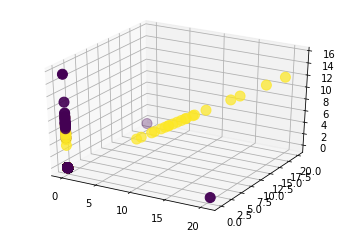

In [36]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics


# #############################################################################
# Generate sample data

X = feature_df
#labels_true = target

#X = feature_df.drop('race',axis=1)
labels_true = feature_df['race']

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 7], X[:, 13] ,X[:, 16], c=y_kmeans, s=100, cmap='viridis')
plt.show()

# #############################################################################
#plt.scatter(X[:, 7], X[:, 16], c=y_kmeans, s=100, cmap='viridis')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='green', s=50, alpha=0.5);

Utilisation de k-means

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(69)

X = feature_df
y = feature_df['race']

estimator = KMeans(n_clusters=3);
title = ['race']

fig1 = plt.figure(1, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
estimator.fit(X)
labels = estimator.labels_
ax.scatter(X.iloc[:, 7], X.iloc[:, 13] ,X.iloc[:, 16], c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title(title)
ax.dist = 12

############# Plot the ground truth
fig2 = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X.iloc[:, 3], X.iloc[:, 0], X.iloc[:, 2], c=y, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title('Ground Truth')
ax.dist = 12


plt.show()

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>